In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Combine models using Voting Classifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Initialize XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
# Evaluate model performance using accuracy and classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Load and Inspect Dataset

In [ ]:
# Load the Telco customer churn dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# df.head()
# df.info()
# df.isnull().sum()
# df.describe()

# Create a backup copy of the original dataset
df_raw = df.copy()

### Data Cleaning

In [15]:
# Convert target column 'Churn' to binary (Yes -> 1, No -> 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
# Convert 'TotalCharges' column to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # 
# Drop rows with missing values
df = df.dropna()
# df.isna().sum()
# Drop customerID column as it is not a predictive feature
df = df.drop('customerID', axis=1)
# Convert categorical Yes/No to binary 1/0
df = df.replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4936\161084743.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})


### EDA: Histograms and Correlation Heatmap

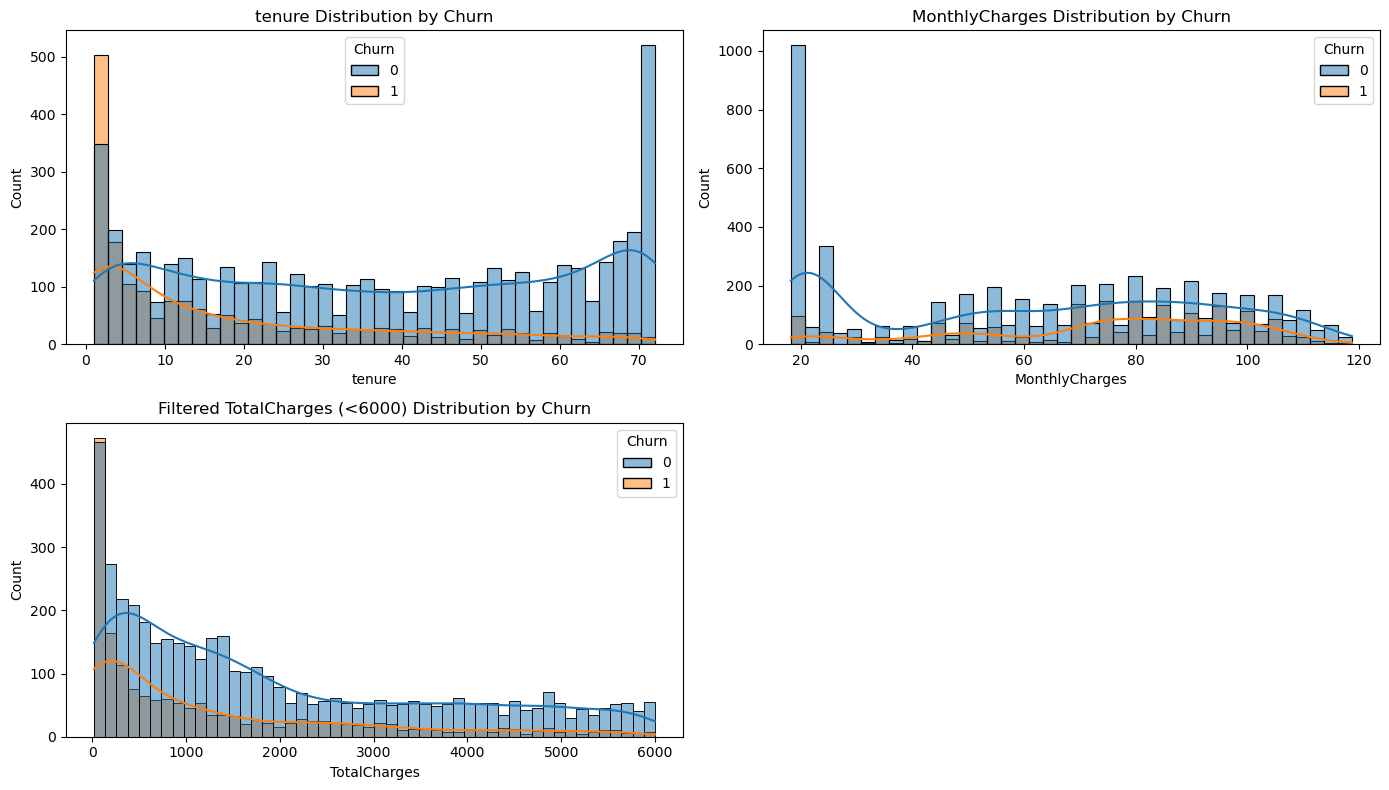

# TotalCharges Statistics
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


In [16]:
df['Churn'].value_counts()
# sns.countplot(data=df_raw, x='Churn') # Visualize the distribution of churn 'bar chart'
# plt.xlabel("Churn")
# plt.title("Customer Churn Distribution")

cols = ['tenure', 'MonthlyCharges', 'TotalCharges (filtered < 6000)']
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
axes = axes.flatten()

# Plot tenure
sns.histplot(data=df, x='tenure', kde=True, hue='Churn', bins=40, ax=axes[0])
axes[0].set_title("tenure Distribution by Churn")

# Plot MonthlyCharges
sns.histplot(data=df, x='MonthlyCharges', kde=True, hue='Churn', bins=40, ax=axes[1])
axes[1].set_title("MonthlyCharges Distribution by Churn")

# Filter TotalCharges
df_filtered = df[df['TotalCharges'] < 6000]
sns.histplot(data=df_filtered, x='TotalCharges', kde=True, hue='Churn', bins=50, ax=axes[2])
axes[2].set_title("Filtered TotalCharges (<6000) Distribution by Churn")

# Remove unused subplot if any
if len(axes) > 3:
    fig.delaxes(axes[3])

plt.tight_layout()
plt.show()

# Show TotalCharges describe separately
print("# TotalCharges Statistics")
print(df['TotalCharges'].describe())

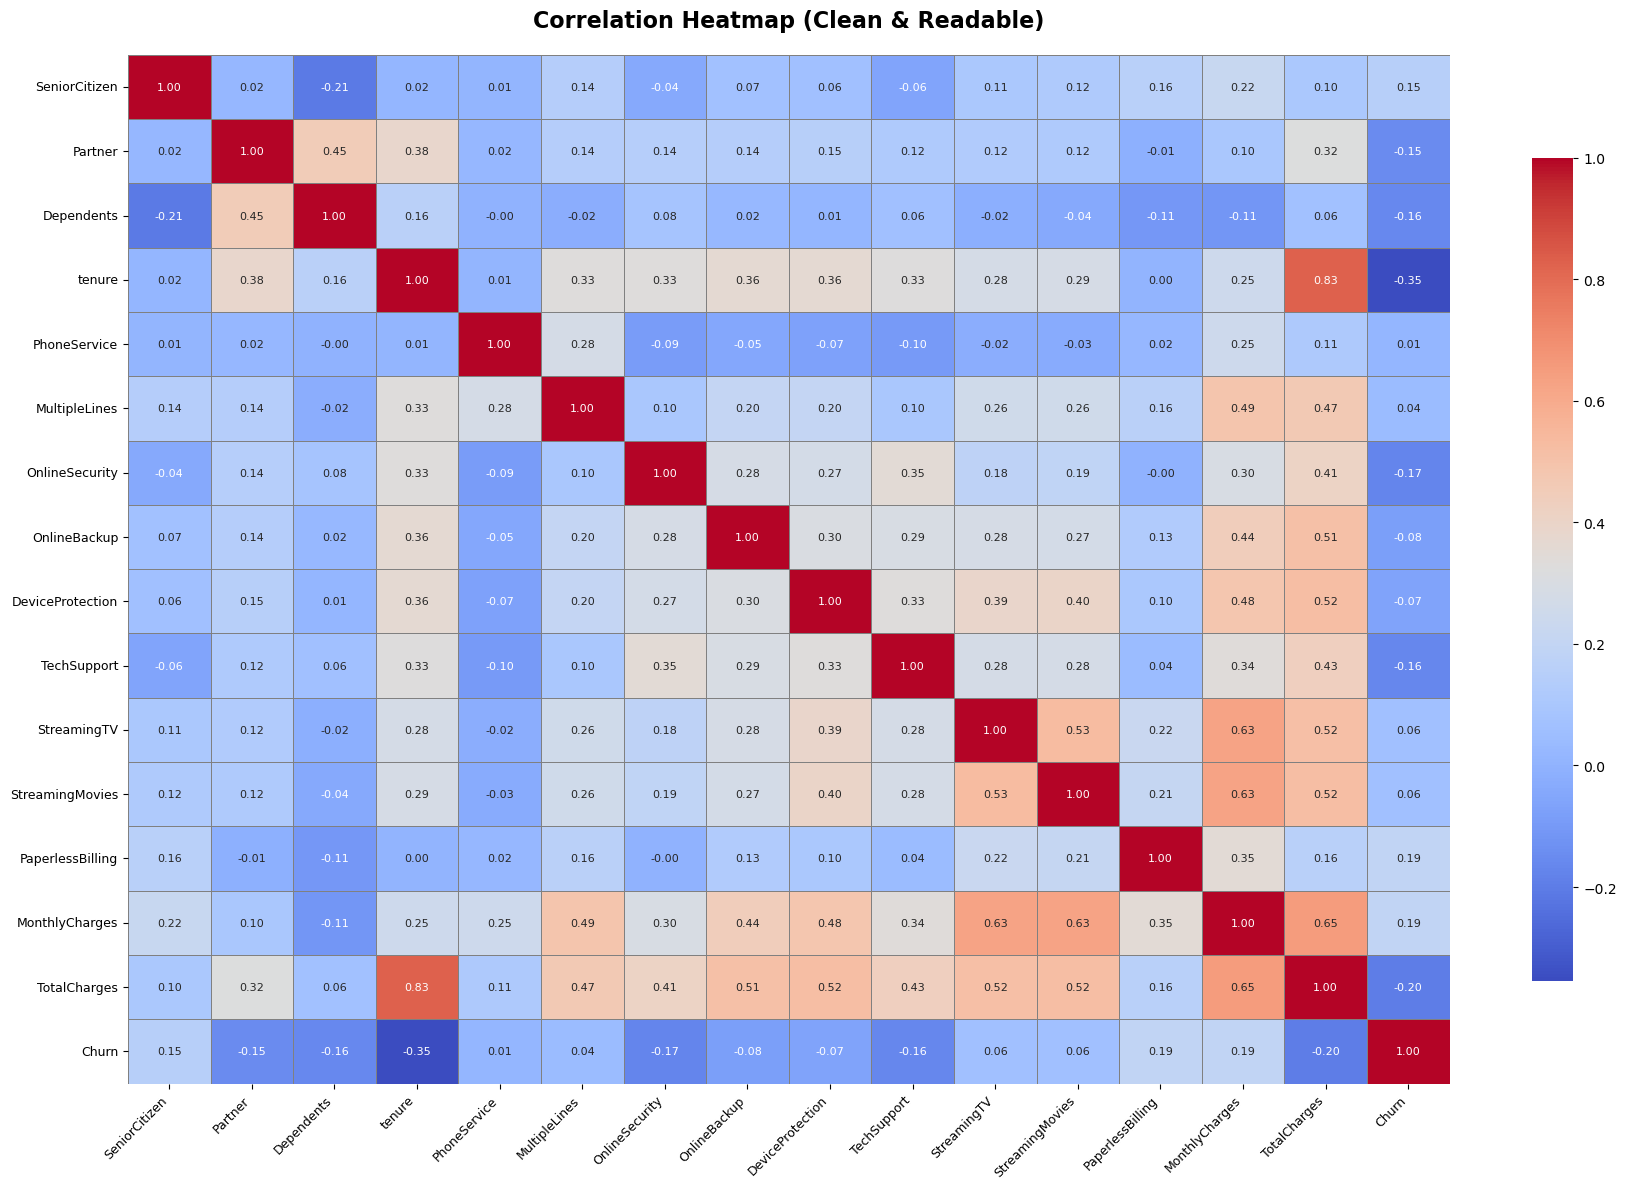

In [17]:
# Correlation Heatmap
plt.figure(figsize=(18, 12))

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap (Clean & Readable)", fontsize=16, pad=20, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

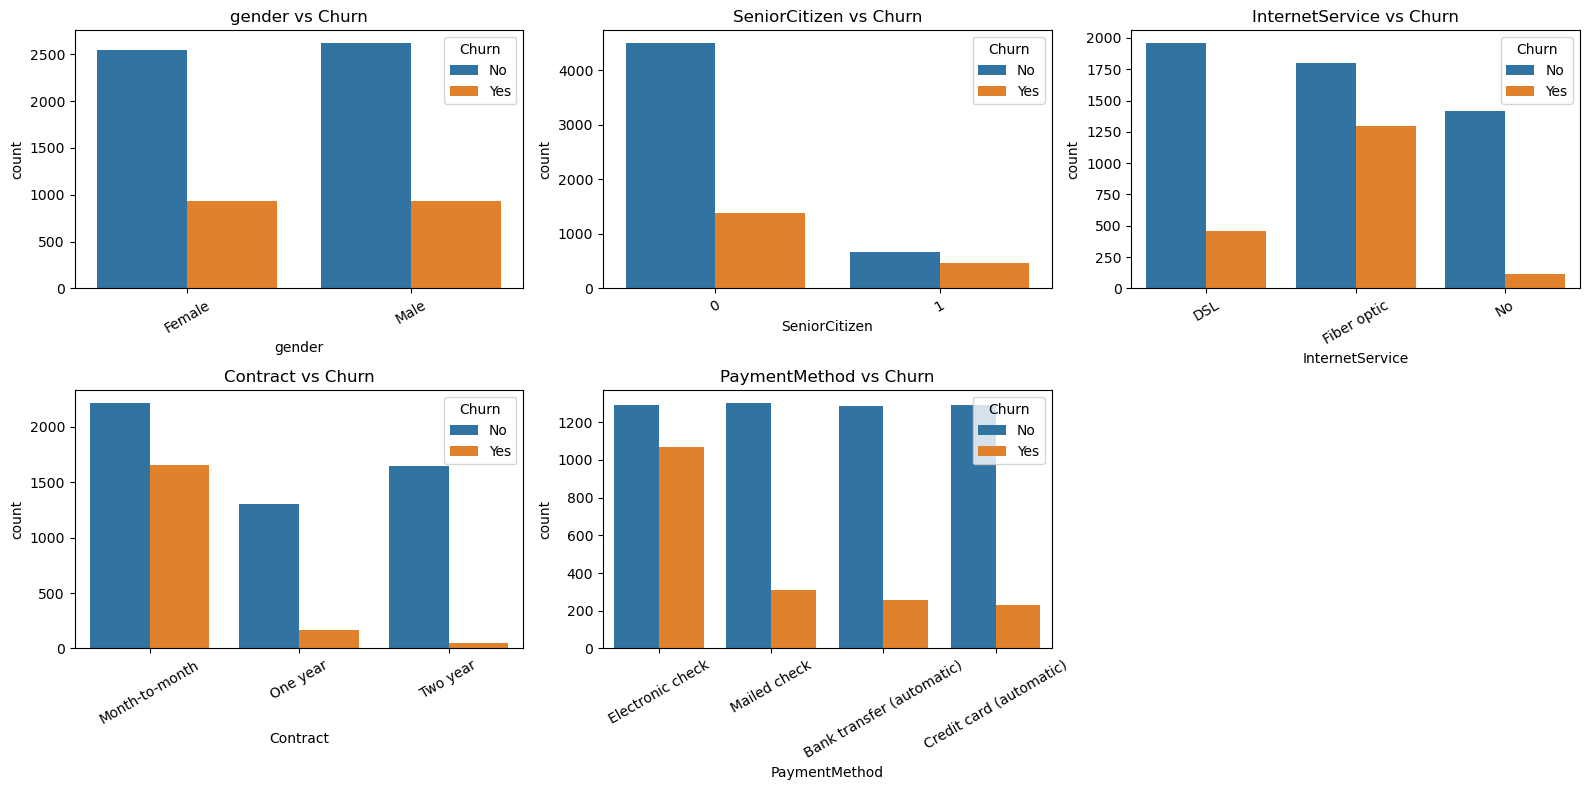

In [18]:
# Categorical Features vs Churn
cols = ['gender', 'SeniorCitizen', 'InternetService', 'Contract', 'PaymentMethod']
n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(cols): 
    sns.countplot(data=df_raw , x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")
    axes[i].tick_params(axis='x', rotation=30)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Feature Engineering

In [19]:
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

df['tenure_group'] = df['tenure'].apply(tenure_group)
df['avg_monthly_charge'] = df['TotalCharges'] / df['tenure']
df['avg_monthly_charge'] = df['avg_monthly_charge'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['is_family'] = ((df['Partner'] == 1) | (df['Dependents'] == 1)).astype(int)

services_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['services_count'] = df[services_cols].apply(lambda row: row.sum(), axis=1)
df['is_streamer'] = ((df['StreamingTV'] == 1) | (df['StreamingMovies'] == 1)).astype(int)

df_raw['support_level'] = (
    (df_raw['TechSupport'] == 'Yes').astype(int) +
    (df_raw['OnlineSecurity'] == 'Yes').astype(int) +
    (df_raw['DeviceProtection'] == 'Yes').astype(int))

df_raw['is_auto_payment'] = df_raw['PaymentMethod'].str.contains('automatic', case=False).astype(int)

df = pd.get_dummies(df, drop_first=True) # 

### Meta Feature - RF Churn Probability

In [20]:
rf_meta = RandomForestClassifier(n_estimators=200, max_features='log2', class_weight='balanced', random_state=42)
X_meta = df.drop(['Churn'], axis=1)
y_meta = df['Churn']
rf_meta.fit(X_meta, y_meta)
df['rf_churn_prob'] = cross_val_predict(rf_meta, X_meta, y_meta, method='predict_proba', cv=5, n_jobs=-1)[:, 1]

df.head()
# df.describe()
# df.info()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-2 years,tenure_group_2-4 years,tenure_group_4-5 years,tenure_group_5+ years,rf_churn_prob
0,0,1,0,1,0,0,0,1,0,0,...,False,False,False,True,False,False,False,False,False,0.42
1,0,0,0,34,1,0,1,0,1,0,...,True,False,False,False,True,False,True,False,False,0.05
2,0,0,0,2,1,0,1,1,0,0,...,False,False,False,False,True,False,False,False,False,0.49
3,0,0,0,45,0,0,1,0,1,1,...,True,False,False,False,False,False,True,False,False,0.03
4,0,0,0,2,1,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,0.53


### Train-Test Split and Scaling

In [21]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
# Fit the scaler on the training set and transform
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train.shape, X_test.shape)
# print(y_train.value_counts())

### Model Training and Evaluation

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
# Initialize XGBoost Classifier
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test)
    print(f"===== {name} =====")
# Evaluate model performance using accuracy and classification report
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

===== Logistic Regression =====
Accuracy : 0.7306
Precision: 0.4959
Recall   : 0.7995
F1 Score : 0.6121
Confusion Matrix:
[[729 304]
 [ 75 299]]
===== Decision Tree =====
Accuracy : 0.7448
Precision: 0.5200
Recall   : 0.5214
F1 Score : 0.5207
Confusion Matrix:
[[853 180]
 [179 195]]
===== Random Forest =====
Accuracy : 0.7875
Precision: 0.6384
Recall   : 0.4626
F1 Score : 0.5364
Confusion Matrix:
[[935  98]
 [201 173]]
===== XGBoost =====
Accuracy : 0.7747
Precision: 0.5888
Recall   : 0.5053
F1 Score : 0.5439
Confusion Matrix:
[[901 132]
 [185 189]]
===== SVM =====
Accuracy : 0.7335
Precision: 0.4992
Recall   : 0.7861
F1 Score : 0.6106
Confusion Matrix:
[[738 295]
 [ 80 294]]


### Feature Importance (Random Forest)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4936\240044107.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=TOP5, x='Importance', y='Feature', palette='rocket')


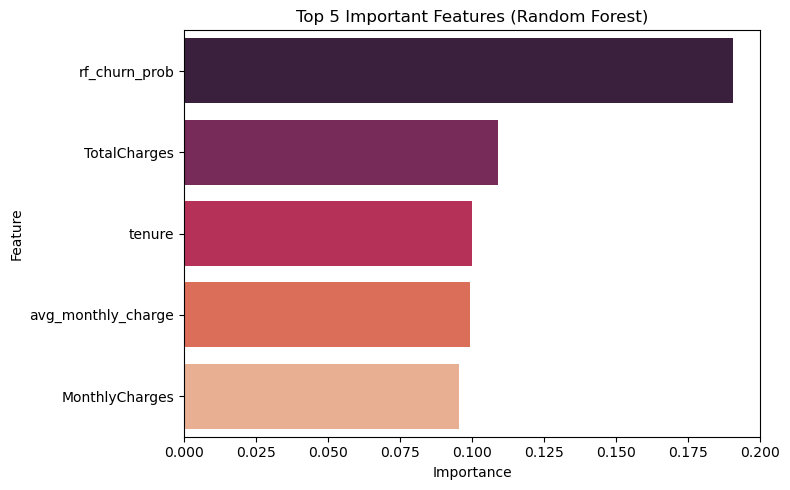

,Feature,Importance
31,rf_churn_prob,0.190602
14,TotalCharges,0.109006
3,tenure,0.099812
15,avg_monthly_charge,0.099123
13,MonthlyCharges,0.095376


In [23]:
# Extracting the Random Forest model from trained models
rf_model = trained_models["Random Forest"]
feature_names = X.columns

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

TOP5 = importance_df.head(5)

plt.figure(figsize=(8, 5))
sns.barplot(data=TOP5, x='Importance', y='Feature', palette='rocket')
plt.title("Top 5 Important Features (Random Forest)")
plt.tight_layout()
plt.show()
TOP5

### GridSearchCV - Random Forest

In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

pred = grid_search.predict(X_test)
# Evaluate model performance using accuracy and classification report
acc = accuracy_score(y_test, pred)
print(f"Test Accuracy: {acc:.4f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Test Accuracy: 0.7939


### Voting Classifier

In [25]:
# Combine models using Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', max_features='log2', random_state=42)),
        ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
# Evaluate model performance using accuracy and classification report
acc = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {acc:.4f}")

Voting Classifier Accuracy: 0.7861


### Stacking Classifier

In [26]:
# Combine models using Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', max_features='log2', random_state=42)),
        ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
    ],
# Initialize Logistic Regression model
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1)
stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
# Evaluate model performance using accuracy and classification report
acc = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {acc:.4f}")

Stacking Classifier Accuracy: 0.7925


### RandomizedSearchCV - XGBoost

In [27]:
# Initialize XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]
}
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

y_pred = random_search.predict(X_test)
# Evaluate model performance using accuracy and classification report
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Random Search Accuracy: {acc:.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Random Search Accuracy: 0.7868


### What I learned:


**Data Cleaning & Preparation**

I made sure the dataset was fully clean by converting columns like TotalCharges to numeric, handling missing values, and removing irrelevant columns. I also encoded all categorical features properly to prepare for modeling.


**Exploratory Data Analysis (EDA)**

I explored the distribution of churn and how it relates to features like tenure, MonthlyCharges, and TotalCharges. I used plots and correlation heatmaps to understand which features might carry real signal, and that really helped shape the rest of the pipeline.


**Feature Engineering**

This part taught me the most. I tried to created new features like:

avg_monthly_charge: to normalize charges over time.
is_family: to reflect customers with partner or dependents.
services_count: to measure how many services the customer uses.
rf_churn_prob: which is a meta feature from a model itself.

These features noticeably improved performance and made me realize how important domain-informed engineering is.

**Modeling & Evaluation**

I trained and compared several models including Logistic Regression, Decision Tree, Random Forest, SVM, and XGBoost. I also tried Voting and Stacking ensembles. I evaluated all models using accuracy, precision, recall, F1 score, and the confusion matrix — and focused on balancing these metrics instead of chasing just one.

**Hyperparameter Tuning**

I applied GridSearchCV on Random Forest and RandomizedSearchCV on XGBoost. This helped me compare the tuned versions with default settings and understand how sensitive models are to hyperparameters.

**Final Thought**

This task wasn’t just about hitting high accuracy, it was about understanding the whole process from raw data to insight, to model, to reflection.
What helped me most was seeing how feature engineering & evaluation can outperform just throwing advanced models at the problem.